## Подготовка

In [ ]:
import pandas as pd
import numpy as np
import warnings
warnings.simplefilter("ignore")

from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyRegressor
from lightgbm import LGBMRegressor
!pip install catboost
from catboost import CatBoostRegressor

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# просмотр, где находится каталог с файлами на COLAB
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# получение доступа к каталогу и уточнение названия папок
import os
os.listdir('/content/drive/My Drive/Colab Notebooks/Яндекс/Проект 10 Прогнозирование заказов такси/ДАННЫЕ')

['taxi.csv']

In [ ]:
# загрузка данных
data = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Яндекс/Проект 10 Прогнозирование заказов такси/ДАННЫЕ/taxi.csv', index_col=[0], parse_dates=[0])

In [ ]:
data = data.sort_index()

In [ ]:
print(data.index.is_monotonic)

True


In [ ]:
data

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
...,...
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [ ]:
data.isna().mean() * 100

num_orders    0.0
dtype: float64

## Вывод

**В результате предварительного анализа, установлено:**

1. Данные представлены за период с 2018-03-01 пo 2018-08-31.
2. Данные насчитывают порядка 26 тыс. строк.
3. Данные представлены с разбивкой по 10 мин.
4. Пропуски в данных отсутствуют. 

## Анализ

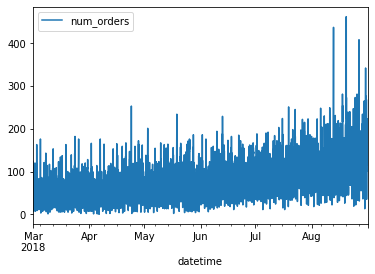

In [ ]:
data_H = data.resample('1H').sum()
data_H.plot();

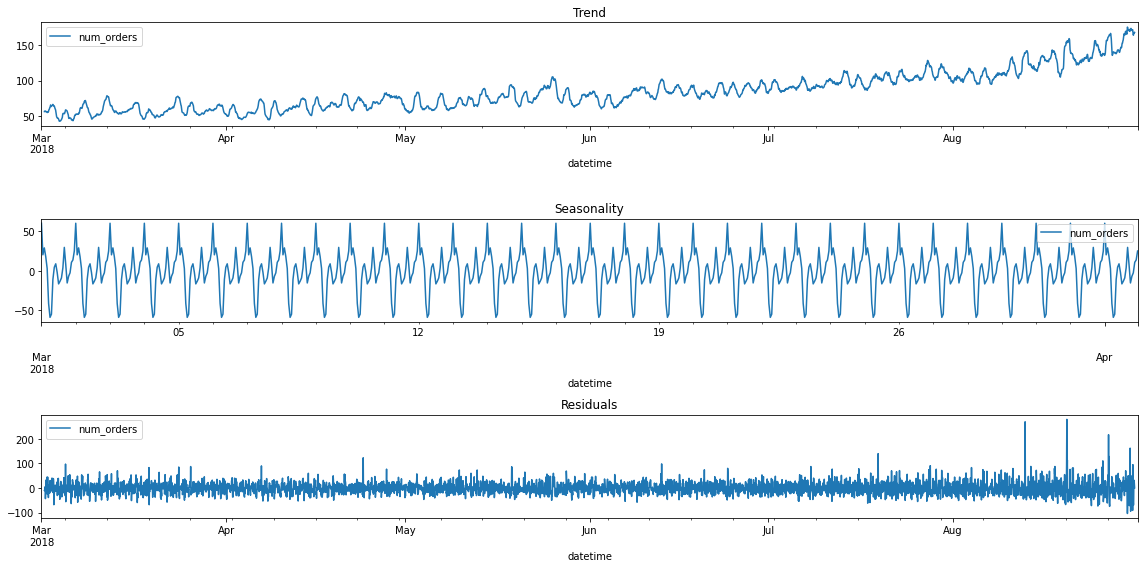

In [ ]:
decomposed = seasonal_decompose(data_H)

plt.figure(figsize=(16, 8))
plt.subplot(311)
# Чтобы график корректно отобразился, указываем его
# оси ax, равными plt.gca() (англ. get current axis,
# получить текущие оси)
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal['2018-03-01':'2018-04-01'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())
plt.title('Residuals')
plt.tight_layout()

In [ ]:
def make_features(data, max_lag, rolling_mean_size):
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour

    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)

    data['rolling_mean'] = data['num_orders'].shift().rolling(rolling_mean_size).mean()
    return data

In [ ]:
data = make_features(data_H, 36, 36)

In [ ]:
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,3,1,3,0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,3,1,3,1,124.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,3,1,3,2,85.0,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,3,1,3,3,71.0,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,3,1,3,4,66.0,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,156.0,91.0,154.0,173.0,156.0,227.0,226.0,166.0,39.0,169.944444
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,254.0,156.0,91.0,154.0,173.0,156.0,227.0,226.0,166.0,172.638889
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,342.0,254.0,156.0,91.0,154.0,173.0,156.0,227.0,226.0,172.305556


In [ ]:
data = data.dropna()

In [ ]:
data

,num_orders,month,day,dayofweek,hour,lag_1,lag_2,lag_3,lag_4,lag_5,...,lag_28,lag_29,lag_30,lag_31,lag_32,lag_33,lag_34,lag_35,lag_36,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 12:00:00,36,3,2,4,12,91.0,54.0,45.0,46.0,7.0,...,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0,55.500000
2018-03-02 13:00:00,45,3,2,4,13,36.0,91.0,54.0,45.0,46.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,53.055556
2018-03-02 14:00:00,44,3,2,4,14,45.0,36.0,91.0,54.0,45.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,51.944444
2018-03-02 15:00:00,59,3,2,4,15,44.0,45.0,36.0,91.0,54.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,51.194444
2018-03-02 16:00:00,82,3,2,4,16,59.0,44.0,45.0,36.0,91.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,51.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-08-31 19:00:00,136,8,31,4,19,207.0,217.0,197.0,116.0,133.0,...,156.0,91.0,154.0,173.0,156.0,227.0,226.0,166.0,39.0,169.944444
2018-08-31 20:00:00,154,8,31,4,20,136.0,207.0,217.0,197.0,116.0,...,254.0,156.0,91.0,154.0,173.0,156.0,227.0,226.0,166.0,172.638889
2018-08-31 21:00:00,159,8,31,4,21,154.0,136.0,207.0,217.0,197.0,...,342.0,254.0,156.0,91.0,154.0,173.0,156.0,227.0,226.0,172.305556


In [ ]:
train, test = train_test_split(data, shuffle=False, test_size=0.1)

In [ ]:
features_train = train.drop(columns=['num_orders'])
target_train = train['num_orders']

features_test = test.drop(columns=['num_orders'])
target_test = test['num_orders']

## Вывод

**В результате анализа данных, установлено:**

1. Данные имеют общий тренд плавного увеличения от марта к августу.
2. Сезонности в данных присутствует (по дням).
3. Остатки представлены временным рядом близким по своей форме к стохастическому стационарному процессу.


## Обучение

### LinearRegression

In [ ]:
%%time
# расчет для LinearRegression
model_LinearRegression = LinearRegression()
model_LinearRegression.fit(features_train, target_train)
y_true = target_train
y_pred = pd.DataFrame(model_LinearRegression.predict(features_train))

result = mean_squared_error(y_true, y_pred)**0.5

print("Модель:", model_LinearRegression)
print("RMSE:", round(result))


Модель: LinearRegression()
RMSE: 25
CPU times: user 19.3 ms, sys: 11.2 ms, total: 30.5 ms
Wall time: 24.5 ms


### RandomForestRegressor

In [ ]:
%%time
# подбор гиперпараметров: глубины дерева, числа деревьев на основе RMSE
best_model_RandomForestRegressor = None
best_result = 100000000
for depth in range(1, 6, 1):
  for est in range(1, 6, 1):
    model = RandomForestRegressor(n_estimators=est, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    
    y_true = target_train
    y_pred = pd.DataFrame(model.predict(features_train))

    result = mean_squared_error(y_true, y_pred)**0.5
    if result < best_result:
      best_model_RandomForestRegressor = model
      best_result = result

print("Лучшие параметры модели:", best_model_RandomForestRegressor)
print("RMSE:", round(best_result))

Лучшие параметры модели: RandomForestRegressor(max_depth=5, n_estimators=5, random_state=12345)
RMSE: 24
CPU times: user 2 s, sys: 43.2 ms, total: 2.05 s
Wall time: 2.06 s


### DecisionTreeRegressor

In [ ]:
%%time
# подбор гиперпараметров: глубины дерева, минимального числа samples_split на основе RMSE
best_model_DecisionTreeRegressor = None
best_result = 100000000
for depth in range(1, 6, 1):
  for spl in range(2, 7, 1):
    model = DecisionTreeRegressor(max_depth=depth, min_samples_split=spl, random_state=12345)
    model.fit(features_train, target_train)
    
    y_true = target_train
    y_pred = pd.DataFrame(model.predict(features_train))

    result = mean_squared_error(y_true, y_pred)**0.5
    if result < best_result:
      best_model_DecisionTreeRegressor = model
      best_result = result

print("Лучшие параметры модели:", best_model_DecisionTreeRegressor)
print("RMSE:", round(best_result))

Лучшие параметры модели: DecisionTreeRegressor(max_depth=5, random_state=12345)
RMSE: 25
CPU times: user 1.3 s, sys: 3.8 ms, total: 1.3 s
Wall time: 1.52 s


### DummyRegressor

In [ ]:
%%time
# подбор гиперпараметров: ['mean', 'median'] на основе RMSE
best_model_DummyRegressor = None
best_result = 100000000
list_strategy = ['mean', 'median']
for strat in list_strategy:
  model = DummyRegressor(strategy=strat)
  model.fit(features_train, target_train)

  y_true = target_train
  y_pred = pd.DataFrame(model.predict(features_train))
  
  result = mean_squared_error(y_true, y_pred)**0.5
  if result < best_result:
    best_model_DummyRegressor = model
    best_result = result

print("Модель:", best_model_DummyRegressor)
print("RMSE:", round(best_result))

Модель: DummyRegressor()
RMSE: 39
CPU times: user 11.4 ms, sys: 1.03 ms, total: 12.4 ms
Wall time: 12 ms


### LGBMRegressor

In [ ]:
%%time
# подбор гиперпараметров: глубины дерева, числа деревьев на основе RMSE
best_model_LGBMRegressor = None
best_result = 100000000
for depth in range(1, 6, 1):
  for est in range(1, 6, 1):
    model = LGBMRegressor(n_estimators=est, max_depth=depth, random_state=12345)
    model.fit(features_train, target_train)
    
    y_true = target_train
    y_pred = pd.DataFrame(model.predict(features_train))

    result = mean_squared_error(y_true, y_pred)**0.5
    if result < best_result:
      best_model_LGBMRegressor = model
      best_result = result

print("Лучшие параметры модели:", best_model_LGBMRegressor)
print("RMSE:", round(best_result))

Лучшие параметры модели: LGBMRegressor(max_depth=5, n_estimators=5, random_state=12345)
RMSE: 30
CPU times: user 3.23 s, sys: 18.3 ms, total: 3.25 s
Wall time: 3.13 s


### CatBoostRegressor

In [ ]:
%%time
# подбор гиперпараметров: глубины дерева, числа деревьев на основе RMSE
best_model_CatBoostRegressor = None
best_result = 100000000
for dep in range(1, 2, 1):
  for sampl in range(1, 2, 1):
    model = CatBoostRegressor(min_child_samples=sampl, depth =dep, random_state=12345)
    model.fit(features_train, target_train)
    
    y_true = target_train
    y_pred = pd.DataFrame(model.predict(features_train))

    result = mean_squared_error(y_true, y_pred)**0.5
    if result < best_result:
      best_model_CatBoostRegressor = model
      best_result = result

print("Лучшие параметры модели:", best_model_CatBoostRegressor)
print("RMSE:", round(best_result))

Learning rate set to 0.050851
0:	learn: 38.1678073	total: 1.51ms	remaining: 1.51s
1:	learn: 37.6677026	total: 3.18ms	remaining: 1.59s
2:	learn: 37.1971126	total: 4.79ms	remaining: 1.59s
3:	learn: 36.7669976	total: 7.17ms	remaining: 1.78s
4:	learn: 36.3643774	total: 8.81ms	remaining: 1.75s
5:	learn: 35.9809241	total: 10.5ms	remaining: 1.73s
6:	learn: 35.6200278	total: 12.9ms	remaining: 1.83s
7:	learn: 35.2869894	total: 14.7ms	remaining: 1.82s
8:	learn: 34.9512441	total: 17.1ms	remaining: 1.89s
9:	learn: 34.6551847	total: 18.9ms	remaining: 1.87s
10:	learn: 34.3516317	total: 21.5ms	remaining: 1.93s
11:	learn: 34.0561904	total: 23.2ms	remaining: 1.91s
12:	learn: 33.7921749	total: 24.8ms	remaining: 1.88s
13:	learn: 33.5312382	total: 27.2ms	remaining: 1.92s
14:	learn: 33.2859539	total: 31.6ms	remaining: 2.07s
15:	learn: 33.0491509	total: 35.1ms	remaining: 2.16s
16:	learn: 32.8157665	total: 38.9ms	remaining: 2.25s
17:	learn: 32.5865015	total: 41.7ms	remaining: 2.27s
18:	learn: 32.3799645	tota

## Вывод

**В результате обучения, установлено:**

1. Модель: LinearRegression();
RMSE: 25;
CPU times: user 19.3 ms.
2. Лучшие параметры модели: RandomForestRegressor(max_depth=5, n_estimators=5, random_state=12345);
RMSE: 24;
CPU times: user 2 s.
3. Лучшие параметры модели: DecisionTreeRegressor(max_depth=5, random_state=12345);
RMSE: 25;
CPU times: user 1.3 s.
4. Модель: DummyRegressor();
RMSE: 39;
CPU times: user 11.4 ms.
5. Лучшие параметры модели: LGBMRegressor(max_depth=5, n_estimators=5, random_state=12345);
RMSE: 30;
CPU times: user 3.23 s.
6. Модель: CatBoostRegressor();
RMSE: 23;
CPU times: user 2.97 s.

## Тестирование

In [ ]:
list_model = [model_LinearRegression, best_model_RandomForestRegressor, best_model_DecisionTreeRegressor, best_model_DummyRegressor, best_model_LGBMRegressor, best_model_CatBoostRegressor]

In [ ]:
# поиск наилучшей модели на ТЕСТОВОЙ выборке
best_model = None
best_result = 100000000
for mod in list_model:
  test_predictions = mod.predict(features_test)
  y_true = target_test
  y_pred = pd.DataFrame(mod.predict(features_test))
  result = mean_squared_error(y_true, y_pred)**0.5
  if result < best_result:
    best_result = result
    best_model = mod

print("Наилучшая модель на ТЕСТОВОЙ выборке:", best_model)
print("RMSE наилучшей модели =", round(best_result))

Наилучшая модель на ТЕСТОВОЙ выборке: LinearRegression()
RMSE наилучшей модели = 48


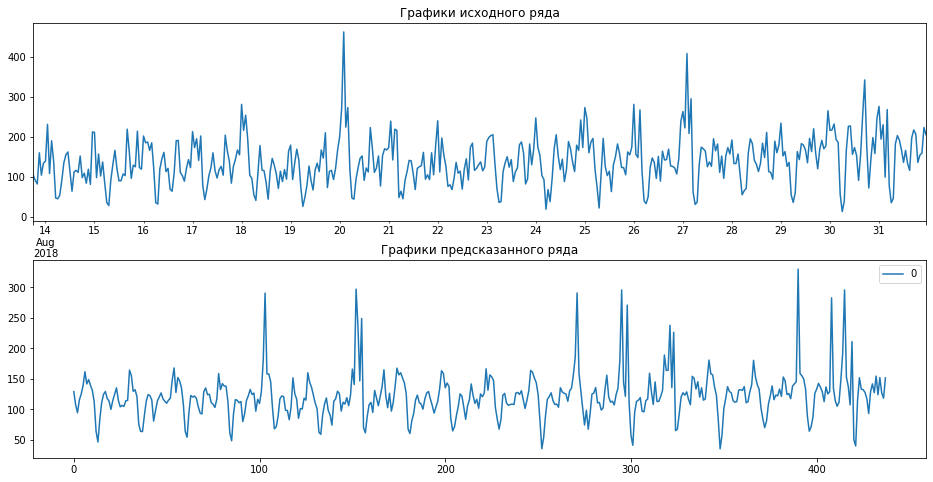

In [ ]:
plt.figure(figsize=(16, 8))

plt.subplot(211)
y_true.plot(ax=plt.gca())
plt.title('Графики исходного ряда')

plt.subplot(212)
y_pred.plot(ax=plt.gca())
plt.title('Графики предсказанного ряда');

## Вывод

**В результате тестирования установлено:**

1. Наилучшая модель на ТЕСТОВОЙ выборке: LinearRegression().
2. RMSE наилучшей модели = 48.

## Общий вывод

**I. В результате предварительного анализа, установлено:**

1. Данные представлены за период с 2018-03-01 пo 2018-08-31.
2. Данные насчитывают порядка 26 тыс. строк.
3. Данные представлены с разбивкой по 10 мин.
4. Пропуски в данных отсутствуют.

**II. В результате анализа данных, установлено:**

1. Данные имеют общий тренд плавного увеличения от марта к августу.
2. Сезонности в данных присутствует (по дням).
3. Остатки представлены временным рядом близким по своей форме к стохастическому стационарному процессу.

**III. В результате обучения, установлено:**

1. Модель: LinearRegression();
RMSE: 25;
CPU times: user 19.3 ms.
2. Лучшие параметры модели: RandomForestRegressor(max_depth=5, n_estimators=5, random_state=12345);
RMSE: 24;
CPU times: user 2 s.
3. Лучшие параметры модели: DecisionTreeRegressor(max_depth=5, random_state=12345);
RMSE: 25;
CPU times: user 1.3 s.
4. Модель: DummyRegressor();
RMSE: 39;
CPU times: user 11.4 ms.
5. Лучшие параметры модели: LGBMRegressor(max_depth=5, n_estimators=5, random_state=12345);
RMSE: 30;
CPU times: user 3.23 s.
6. Модель: CatBoostRegressor();
RMSE: 23;
CPU times: user 2.97 s.

**IV. В результате тестирования, установлено:**

1. Наилучшая модель на ТЕСТОВОЙ выборке: LinearRegression().
2. RMSE наилучшей модели = 48.